<a href="https://colab.research.google.com/github/Alimoh20/Sentiment-analysis-using-Bert-and-GPT2/blob/main/Sentiment%20analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:


1.  (12/7 Pretrained LLMs) https://colab.research.google.com/drive/1-rVaY7ZzThRWKXVJK9hnO4fi0V-zmPGb?usp=sharing
2.   https://huggingface.co/docs/transformers/model_doc/bert
3.  https://pytorch.org/docs/stable/index.html
4.  My previous assingments 3 and 4.




#Comment
To run the code, first, you need to access to the dataset provided in Kaggle. So, you will need authenticate with Kaggle using kaggle.json. To do so, please follow this:
1.   Navigate to https://www.kaggle.com.
2.   Log in with your account
3.   Then go to "Your Profile"
4.   Go to Account tab in your profile
5.   From API part, click "Create New API Token"
6.   This will trigger the download of kaggle.json, a file containing your API credentials.
7.   Then get back here, and connect Google Colab by clicking on Connect.
8.   Now, from the left part, find Files section.
9.   Click on "Upload to session storage" and select the Kaggle.json file you have already downloaded.

Please run the cells in order they are appeared.

Consider that, the code are divided into four sections:
1. Requirements: which includes importing required packages like transfromers.
2. Bert model
   1. Bert requirement.
   2. BERT, Motivational task, config 1-6
   3. BERT, Sentiment task, config 1-6 
3. GPT2 model
   1. GPT2 requirement
   2. GPT2, Motivational task, config 7-12
   3. GPT2, Sentiment task, config 7-12
4. Downloading output

Thank you for your patience!

# Requirement function and imports


In [ ]:
!pip install conllu
import conllu
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## Google Colab
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Loading dataset from kaggle
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d williamscott701/memotion-dataset-7k

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 97% 673M/695M [00:05<00:00, 170MB/s]
100% 695M/695M [00:05<00:00, 142MB/s]


In [ ]:
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [ ]:
import pandas as pd
import sklearn
import unicodedata
import numpy as np
import random
import re
import nltk
from nltk.corpus import movie_reviews
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
import transformers

from transformers import BertTokenizer, TFBertForSequenceClassification, BertModel
import torch.nn as nn

In [ ]:
! unzip '/content/memotion-dataset-7k.zip'

Streaming output truncated to the last 5000 lines.
  inflating: memotion_dataset_7k/images/image_2798.png  
  inflating: memotion_dataset_7k/images/image_2799.png  
  inflating: memotion_dataset_7k/images/image_28.jpg  
  inflating: memotion_dataset_7k/images/image_280.jpg  
  inflating: memotion_dataset_7k/images/image_2800.png  
  inflating: memotion_dataset_7k/images/image_2801.png  
  inflating: memotion_dataset_7k/images/image_2802.png  
  inflating: memotion_dataset_7k/images/image_2803.png  
  inflating: memotion_dataset_7k/images/image_2804.png  
  inflating: memotion_dataset_7k/images/image_2805.jpg  
  inflating: memotion_dataset_7k/images/image_2806.jpg  
  inflating: memotion_dataset_7k/images/image_2807.jpg  
  inflating: memotion_dataset_7k/images/image_2808.jpg  
  inflating: memotion_dataset_7k/images/image_2809.png  
  inflating: memotion_dataset_7k/images/image_281.png  
  inflating: memotion_dataset_7k/images/image_2810.jpg  
  inflating: memotion_dataset_7k/images/i

In [ ]:
import collections
df = pd.read_csv('/content/memotion_dataset_7k/labels.csv')
# df = pd.read_csv('labels.csv')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
# df = df.drop(columns = ['text_ocr', 'humour', 'sarcasm', 'offensive', 'motivational'])
df = df.drop(columns=['image_name','text_ocr'])
df.head()

cleaned = df.copy()
cleaned.dropna(inplace=True)
cleaned.isnull().any()

labels_type = {'humour':1, 'sarcasm':2, 'offensive':3, 'motivational':4, 'overall_sentiment':5}

humour_set=list(set(df['humour']))
sarcasm_set = list(set(df['sarcasm']))
offensive_set = list(set(df['offensive']))
motivational_set = list(set(df['motivational']))
# overall_sentiment_set = list(set(df['overall_sentiment']))
overall_sentiment_dict = {'positive':2, 'negative':0, 'very_negative':0, 'very_positive':2, 'neutral':1}



humour_dict ={humour_set[i]: i for i in range(len(humour_set))}
sarcasm_dict ={sarcasm_set[i]: i for i in range(len(sarcasm_set))}
offensive_dict ={offensive_set[i]: i for i in range(len(offensive_set))}
motivational_dict ={motivational_set[i]: i for i in range(len(motivational_set))}
# overall_sentiment_dict ={overall_sentiment_set[i]: i for i in range(len(overall_sentiment_set))}

df=df.replace({'humour': humour_dict})
df=df.replace({'sarcasm': sarcasm_dict})
df=df.replace({'offensive': offensive_dict})
df=df.replace({'motivational': motivational_dict})
df=df.replace({'overall_sentiment': overall_sentiment_dict})
dataset_list= df.values.tolist()

In [ ]:
def create_dataset(Classification_lapel_type = 'motivational'):
  #column_in_table: 1:'humour', 2:'sarcasm', 3:'offensive', 4:'motivational', 5: 'overall_sentiment'
  dataset = [[dataset_list[i][0],dataset_list[i][labels_type[Classification_lapel_type]]]
            for i in range(len(dataset_list))]
  train_set, theOther = train_test_split(dataset, test_size=0.4, random_state=42)
  val_set, test_set = train_test_split(theOther, test_size=0.5, random_state=42)

  x_train = np.array([t for (t, l) in train_set])
  y_train = np.array([l for (t, l) in train_set])

  x_val = np.array([t for (t,l) in val_set])   
  y_val = np.array([l for (t, l) in val_set])

  x_test = np.array([t for (t,l) in test_set])
  y_test = np.array([l for (t, l) in test_set])

  from collections import Counter
  print('Data distribution:')
  print('Training distribution per label', Counter([d for d in y_train]))
  print('Val distribution per label', Counter([d for d in y_val]))
  print('Test distribution per label', Counter([d for d in y_test]))

  return x_train,y_train,x_val,y_val,x_test,y_test

In [ ]:
def print_results(acc, macp, macr, micp, micr,f1, datasettype, rounded=-1):
  if rounded==-1:
    print("Metrics for "+datasettype+" data:")
    print("Accuracy score:", (acc))
    print("macro precision:", macp)
    print("macro recall:", macr)
    print("micro precision", micp)
    print("micro recall",micr)
    print("F1 score:",f1 )
  elif rounded>=0:
    print("Metrics for "+datasettype+" data:")
    print("Accuracy score:", round(acc, rounded))
    print("macro precision:", round(macp, rounded))
    print("macro recall:", round(macr, rounded))
    print("micro precision", round(micp, rounded))
    print("micro recall",round(micr, rounded))
    print("F1 score:",round(f1 , rounded))

In [ ]:
import numpy
def train(
          classifier,
          label_type,
          config,
          trn,
          trn_labels ,
          val ,
          val_labels ,
          weight_adjuster,
          loss_fn,
          batch_size=32,
          num_epochs=10):
  
  loss_epochs = []
  accuracy_epochs =[]
  accuracy_epochs_val = []
  loss_epochs_val = []

  print('****************** Training ******************')

  for epoch in range(num_epochs):
    print("Epoch %d" % epoch,end='')
    batch_start = 0
    losses = 0
    accuracies = 0
    batch_end = min(batch_size, len(trn))
    num_batches = int(numpy.ceil(len(trn) / batch_size))
    for batch_idx, batch in enumerate(range(num_batches)):
      batch = trn[batch_start:batch_end][:]

      weight_adjuster.zero_grad()
      logits = classifier(batch)
      labels = trn_labels[batch_start:batch_end]
      loss = loss_fn(input=logits, target=labels)

      accuracies += accuracy_score(labels.cpu(), logits.argmax(dim=1).cpu())
      losses += loss
      loss.backward()

      weight_adjuster.step()

      batch_start = batch_end
      batch_end = batch_end+batch_size
      batch_end = min(batch_end, len(trn))

    loss_epochs.append((losses/num_batches).detach().numpy())
    accuracy_epochs.append(accuracies/num_batches)

    predictions, logit_val = classifier.predict(val)
    accuracy = accuracy_score(val_labels, predictions)
    accuracy_epochs_val.append(accuracy)
    loss_val = loss_fn(input=logit_val,target=torch.LongTensor(val_labels))

    loss_epochs_val.append(loss_val.detach().numpy())
    print(" ( acc_train:%.3f, " % float(accuracies/num_batches),"acc_dev:%.3f )." % float(accuracy))

  plotdata(config, label_type, TrainingAcuracy= accuracy_epochs, DevAccuracy= accuracy_epochs_val, Test = None, type_plt="Accuracy")
  plotdata(config, label_type, TrainingAcuracy= loss_epochs, DevAccuracy= loss_epochs_val, Test = None, type_plt="Loss")

In [ ]:
def vectorized_features(data,feature_vectorization = 0):
  data1 = data
  try:
    print('Featurizing fast ...')
    if feature_vectorization==0:
      data = torch.concat(data)
      data=data.reshape(data.shape[0],-1)
    elif feature_vectorization==1:
      data = torch.concat(data)
      data= data.mean(dim=1)
    data = data.cpu()
    return data

  except:
    data = data1
    print('Featurizing slow ...')
    sample_num = len(data)
    if feature_vectorization==0:
      item = data[0]
      number_features =item.shape[0]*item.shape[1]
      expand_bert_fts =torch.zeros(sample_num,number_features)
      k=0
      for sample in data:
          expand_bert_fts[k,:]=torch.FloatTensor(torch.FloatTensor(list(chain.from_iterable(sample))))
          k += 1
          # print(k)
    elif feature_vectorization==1:
      item = data[0]
      number_features =item.shape[1]
      expand_bert_fts =torch.zeros(sample_num,number_features)
      k=0
      for sample in data:
          expand_bert_fts[k,:]=torch.FloatTensor(torch.FloatTensor(list(sample.mean(dim=0))))
          k += 1
          # print(k)
      return expand_bert_fts

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
def plotdata(config, label_type, TrainingAcuracy=None,DevAccuracy=None,Test=None,type_plt="Accuracy"):
  indecis = [i for i in range(len(TrainingAcuracy))]
  # plotting the Training 
  if TrainingAcuracy is not None:
      plt.plot(indecis,TrainingAcuracy, label = "Train")
  
  # plotting the dev
  if DevAccuracy is not None:
     plt.plot(indecis,DevAccuracy, label = "Dev")
  plt.title('Train and Dev '+type_plt)
  if Test is not None:
    Test_expand = [Test for i in range(len(TrainingAcuracy))]
    #Plotting the Test
    plt.plot(indecis,Test_expand,label = "Test")
    plt.title('Train, Dev and Test '+type_plt)

  plt.xlabel('Epochs')
  plt.ylabel( type_plt)
 
  plt.legend()
  plt.savefig('output_'+label_type+'/'+type_plt+'('+str(config)+')'+'.jpg')
  print('output_'+label_type+'/'+type_plt+'('+str(config)+')'+'.jpg saved!')
  plt.show()

In [ ]:
class Sentimentclassifier(nn.Module):
  def __init__(self, num_features, num_hidden1,
               num_hidden2,num_labels, drop_out = 0.2):
    super(Sentimentclassifier, self).__init__()

    self.num_features = num_features
    self.num_labels = num_labels

    self.l1 = nn.Linear(in_features= self.num_features, out_features=num_hidden1)
    self.d1 = nn.Dropout(drop_out)
    self.l2 = nn.Linear(in_features= num_hidden1, out_features=num_hidden2)
    self.d2 = nn.Dropout(drop_out)
    self.logit_scorer = nn.Linear(in_features= num_hidden2, out_features=num_labels)

  def forward(self, input):
    output = self.l1(input)
    output = self.d1(output)
    output = self.l2(output)
    output = self.d2(output)
    logits = self.logit_scorer(output)
    return logits 

  def predict(self, input):
    logits = self.forward(input);
    return logits.argmax(dim=1), logits

In [ ]:
def featurized_data(x_train,y_train,
                    x_val,y_val,
                    x_test,y_test,
                    featurizer, feature_vectorization=0):
  featurized_train = featurizer(x_train,y_train)
  # print("*******shape::::",featurized_train[0])
  # print("*******shape::::",len(featurized_train),len(featurized_train[0]),len(featurized_train[0][0]),len(featurized_train[0][0][0]))
  featurized_train = vectorized_features(featurized_train,feature_vectorization) 
  # print("*******shape::::",np.shape(featurized_train))
  # exit()

  featurized_val = featurizer(x_val,y_val)
  featurized_val = vectorized_features(featurized_val,feature_vectorization)

  featurized_test = featurizer(x_test,y_test)
  featurized_test = vectorized_features(featurized_test,feature_vectorization)
    
  return featurized_train,featurized_val,featurized_test

In [ ]:
import os.path
from os import path

if path.exists('output_motivational') == False:
  os.mkdir('output_motivational')
if path.exists('output_overall_sentiment') == False:
  os.mkdir('output_overall_sentiment')

# **Bert Models**

## Bert requirement

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
class FeatureBertRepresentation:
  def __init__(self,
               bert_batch_size,
               max_length,
               bert_model_type='bert-base-uncased'               
               ):
    # received the train,dev, test dataset
    # find the bert representation of the data and save it

    self.bert_model_type = bert_model_type
    self.max_length = max_length
    self.batch_size= bert_batch_size
    self.model = BertModel.from_pretrained(bert_model_type,
                                  output_hidden_states = True)

  def __call__(self, x, y):
    self.model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # device = torch.device('cuda:0')
    self.model.to(device)
    self.model.eval()

    # print('len before prepared',self.max_length)
    prepared_data = self.prepare_data(x, y, self.max_length)
    hidden_states=[]

    for batch in prepared_data:
      batch = tuple(b.to(device) for b in batch)
        
      inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1]
                  }
      with torch.no_grad():
        outputs = self.model(**inputs)
      hidden_states.append(outputs[2][0])
    return hidden_states
    

    
  def prepare_data(self, 
                   data,
                   labels,
                   max_length, 
                   add_special_tokens=True, 
                   return_attention_mask=True, 
                   pad_to_max_length=True ):
      
      tokenizer = BertTokenizer.from_pretrained(self.bert_model_type, 
                                            do_lower_case=True,
                                            output_hidden_states = True)
      encoded_data = tokenizer.batch_encode_plus(data,
                                                add_special_tokens=add_special_tokens, 
                                                return_attention_mask=return_attention_mask, 
                                                pad_to_max_length=pad_to_max_length, 
                                                max_length=self.max_length, 
                                                return_tensors='pt')
      input_ids_data = encoded_data['input_ids']
      attention_masks_data = encoded_data['attention_mask']
      labels_data = torch.tensor(labels)

      encoded_data = tf.concat([input_ids_data,attention_masks_data],1)
      encoded_data = np.array(encoded_data)

      encoded_data = torch.Tensor(encoded_data)
      encoded_data= encoded_data.type(torch.int)

      input_ids, attention_masks = torch.split(encoded_data,self.max_length, 1)
      input_ids=input_ids.type(torch.int)
      attention_masks = attention_masks.type(torch.int)

      dataset = TensorDataset(input_ids, attention_masks, torch.tensor(labels))
      
      dataloader_data = DataLoader(dataset, 
                                sampler=RandomSampler(dataset), 
                                batch_size=self.batch_size)
      return dataloader_data

In [ ]:
def bert_configuration_run(
    config_num,
    label_type = 'overall_sentiment',   # Values: 'humour', 'sarcasm','offensive', 'motivational', or 'overall_sentiment'
    max_length = 32,                    # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 0           # Either averaging (=1) over all of words or concatenating(=0).
    ):
  batch_size=150
  num_epochs=100
  lr = 0.0001 # 0.01, 0.001, 0.0001
  drop_out = 0.4

  x_train,y_train,x_val,y_val,x_test,y_test = create_dataset(label_type)

  feature_bert = FeatureBertRepresentation(batch_size,max_length)
  bert_train_flattened,bert_val_flattened, bert_test_flattened = featurized_data(
      x_train,y_train,
      x_val,y_val,
      x_test,y_test,
      featurizer=feature_bert,
      feature_vectorization = feature_vectorization)
  
  num_features=np.shape(bert_train_flattened)[1]
 

  model = Sentimentclassifier(num_features,
                            num_hidden1 = 2096, 
                            num_hidden2 = 32,
                            num_labels=len(set(y_train)),
                            drop_out = drop_out)
  weight_adjuster = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
  # weight_adjuster = torch.optim.Adam(model.parameters(), lr=lr)
  loss_fn = nn.CrossEntropyLoss()

  feature_vec= ['Concatenation', 'Averaging']

  train(model,
      label_type,
      config = config_num,
      trn = torch.FloatTensor(bert_train_flattened),
      trn_labels = torch.tensor(y_train),
      val = torch.FloatTensor(bert_val_flattened),
      val_labels = torch.tensor(y_val),
      
      weight_adjuster=weight_adjuster,
      loss_fn=loss_fn,
      batch_size = batch_size,
      num_epochs = num_epochs)

  y_test = torch.LongTensor(y_test)
  predictions, _ = model.predict(torch.FloatTensor(bert_test_flattened))

  accuracy = accuracy_score(y_test, predictions)
  macro_precision = precision_score(y_test, predictions, average='macro')
  macro_recall = recall_score(y_test, predictions, average='macro')
  micro_precision = precision_score(y_test, predictions, average='micro')
  micro_recall = recall_score(y_test, predictions, average='micro')
  f1_score =  2*(macro_precision*macro_recall)/(macro_precision+macro_recall)

  print('********** Configuration: ', str(config_num))
  print('Classification type: ', label_type)
  print('Max length of sentence: ', max_length)
  print('Cat or Ave over the output:', feature_vec[feature_vectorization])
  print('Batch size: ', batch_size)
  print('Number of features:',np.shape(bert_train_flattened)[1])
  print('Epochs: ', num_epochs)
  print('********** Results:')

  print_results(accuracy, macro_precision, macro_recall, micro_precision, micro_recall, f1_score, 'test', rounded=3)
  print('Configuration number ',str(config_num)+' has been runned successfully.') 

## BERT, Motivational, config 1-6

### Config 1 (Concatenation, 32)

Data distribution:
Training distribution per label Counter({1: 2711, 0: 1484})
Val distribution per label Counter({1: 888, 0: 510})
Test distribution per label Counter({1: 926, 0: 473})


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max 

Featurizing fast ...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Featurizing fast ...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Featurizing fast ...
****************** Training ******************
Epoch 0 ( acc_train:0.586,  acc_dev:0.631 ).
Epoch 1 ( acc_train:0.641,  acc_dev:0.639 ).
Epoch 2 ( acc_train:0.642,  acc_dev:0.634 ).
Epoch 3 ( acc_train:0.645,  acc_dev:0.632 ).
Epoch 4 ( acc_train:0.644,  acc_dev:0.634 ).
Epoch 5 ( acc_train:0.648,  acc_dev:0.635 ).
Epoch 6 ( acc_train:0.647,  acc_dev:0.633 ).
Epoch 7 ( acc_train:0.648,  acc_dev:0.637 ).
Epoch 8 ( acc_train:0.648,  acc_dev:0.632 ).
Epoch 9 ( acc_train:0.647,  acc_dev:0.637 ).
Epoch 10 ( acc_train:0.646,  acc_dev:0.634 ).
Epoch 11 ( acc_train:0.647,  acc_dev:0.636 ).
Epoch 12 ( acc_train:0.648,  acc_dev:0.634 ).
Epoch 13 ( acc_train:0.648,  acc_dev:0.636 ).
Epoch 14 ( acc_train:0.647,  acc_dev:0.637 ).
Epoch 15 ( acc_train:0.648,  acc_dev:0.636 ).
Epoch 16 ( acc_train:0.649,  acc_dev:0.637 ).
Epoch 17 ( acc_train:0.650,  acc_dev:0.633 ).
Epoch 18 ( acc_train:0.650,  acc_dev:0.634 ).
Epoch 19 ( acc_train:0.651,  acc_dev:0.633 ).
Epoch 20 ( acc_train:0

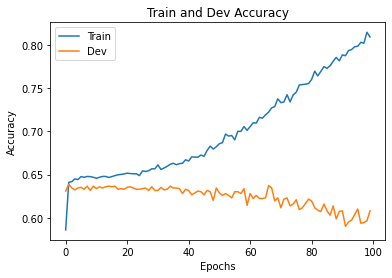

output_motivational/Loss(1).jpg saved!


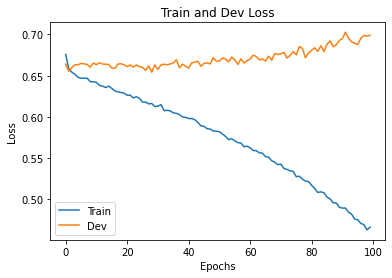

********** Configuration:  1
Classification type:  motivational
Max length of sentence:  32
Cat or Ave over the output: Concatenation
Batch size:  150
Number of features: 24576
Epochs:  100
********** Results:
Metrics for test data:
Accuracy score: 0.609
macro precision: 0.497
macro recall: 0.498
micro precision 0.609
micro recall 0.609
F1 score: 0.498
Configuration number  1 has been runned successfully.


In [ ]:
bert_configuration_run(
    config_num = 1,
    label_type = 'motivational', # Values: 'humour', 'sarcasm','offensive', 'motivational', or 'overall_sentiment'
    max_length = 32,             # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 0)    # Either averaging (=1)  or concatenating(=0) over all of words.

### Config 2 (Concatenation, 64)

Data distribution:
Training distribution per label Counter({1: 2711, 0: 1484})
Val distribution per label Counter({1: 888, 0: 510})
Test distribution per label Counter({1: 926, 0: 473})


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max 

Featurizing fast ...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Featurizing fast ...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Featurizing fast ...
****************** Training ******************
Epoch 0 ( acc_train:0.622,  acc_dev:0.634 ).
Epoch 1 ( acc_train:0.646,  acc_dev:0.636 ).
Epoch 2 ( acc_train:0.645,  acc_dev:0.634 ).
Epoch 3 ( acc_train:0.647,  acc_dev:0.635 ).
Epoch 4 ( acc_train:0.645,  acc_dev:0.635 ).
Epoch 5 ( acc_train:0.648,  acc_dev:0.635 ).
Epoch 6 ( acc_train:0.647,  acc_dev:0.635 ).
Epoch 7 ( acc_train:0.646,  acc_dev:0.634 ).
Epoch 8 ( acc_train:0.646,  acc_dev:0.637 ).
Epoch 9 ( acc_train:0.647,  acc_dev:0.636 ).
Epoch 10 ( acc_train:0.646,  acc_dev:0.636 ).
Epoch 11 ( acc_train:0.647,  acc_dev:0.632 ).
Epoch 12 ( acc_train:0.647,  acc_dev:0.636 ).
Epoch 13 ( acc_train:0.647,  acc_dev:0.634 ).
Epoch 14 ( acc_train:0.648,  acc_dev:0.635 ).
Epoch 15 ( acc_train:0.648,  acc_dev:0.636 ).
Epoch 16 ( acc_train:0.647,  acc_dev:0.634 ).
Epoch 17 ( acc_train:0.649,  acc_dev:0.636 ).
Epoch 18 ( acc_train:0.647,  acc_dev:0.633 ).
Epoch 19 ( acc_train:0.649,  acc_dev:0.633 ).
Epoch 20 ( acc_train:0

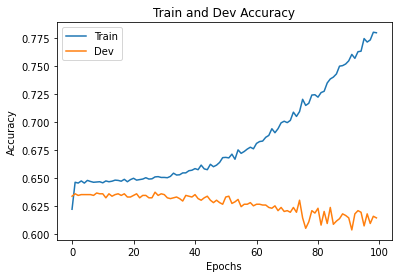

output_motivational/Loss(2).jpg saved!


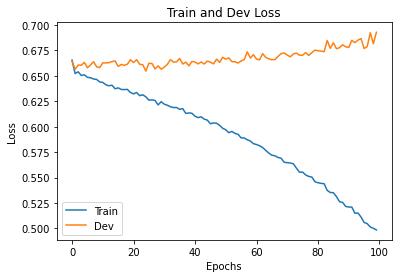

********** Configuration:  2
Classification type:  motivational
Max length of sentence:  64
Cat or Ave over the output: Concatenation
Batch size:  150
Number of features: 49152
Epochs:  100
********** Results:
Metrics for test data:
Accuracy score: 0.636
macro precision: 0.475
macro recall: 0.493
micro precision 0.636
micro recall 0.636
F1 score: 0.484
Configuration number  2 has been runned successfully.


In [ ]:
bert_configuration_run(
    config_num = 2,
    label_type = 'motivational',  # Values: 'motivational', 'overall_sentiment', (or 'humour', 'sarcasm','offensive')
    max_length = 64,              # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 0)    # Either averaging (=1) over all of words or concatenating(=0).

### Config 3 (Concatenation, 128)

Data distribution:
Training distribution per label Counter({1: 2711, 0: 1484})
Val distribution per label Counter({1: 888, 0: 510})
Test distribution per label Counter({1: 926, 0: 473})


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max 

Featurizing fast ...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Featurizing fast ...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Featurizing fast ...
****************** Training ******************
Epoch 0 ( acc_train:0.630,  acc_dev:0.637 ).
Epoch 1 ( acc_train:0.646,  acc_dev:0.637 ).
Epoch 2 ( acc_train:0.645,  acc_dev:0.635 ).
Epoch 3 ( acc_train:0.645,  acc_dev:0.634 ).
Epoch 4 ( acc_train:0.646,  acc_dev:0.637 ).
Epoch 5 ( acc_train:0.645,  acc_dev:0.636 ).
Epoch 6 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 7 ( acc_train:0.645,  acc_dev:0.635 ).
Epoch 8 ( acc_train:0.648,  acc_dev:0.634 ).
Epoch 9 ( acc_train:0.646,  acc_dev:0.634 ).
Epoch 10 ( acc_train:0.646,  acc_dev:0.634 ).
Epoch 11 ( acc_train:0.648,  acc_dev:0.634 ).
Epoch 12 ( acc_train:0.647,  acc_dev:0.635 ).
Epoch 13 ( acc_train:0.648,  acc_dev:0.635 ).
Epoch 14 ( acc_train:0.648,  acc_dev:0.635 ).
Epoch 15 ( acc_train:0.649,  acc_dev:0.634 ).
Epoch 16 ( acc_train:0.649,  acc_dev:0.634 ).
Epoch 17 ( acc_train:0.649,  acc_dev:0.633 ).
Epoch 18 ( acc_train:0.649,  acc_dev:0.635 ).
Epoch 19 ( acc_train:0.647,  acc_dev:0.634 ).
Epoch 20 ( acc_train:0

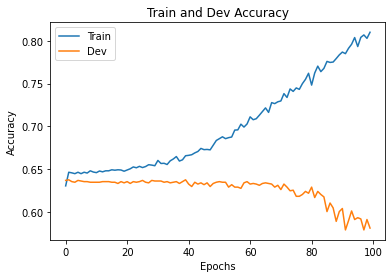

output_motivational/Loss(3).jpg saved!


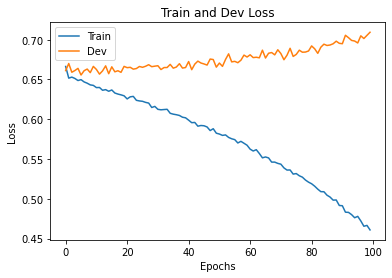

********** Configuration:  3
Classification type:  motivational
Max length of sentence:  128
Cat or Ave over the output: Concatenation
Batch size:  150
Number of features: 98304
Epochs:  100
********** Results:
Metrics for test data:
Accuracy score: 0.596
macro precision: 0.494
macro recall: 0.496
micro precision 0.596
micro recall 0.596
F1 score: 0.495
Configuration number  3 has been runned successfully.


In [ ]:
bert_configuration_run(
    config_num= 3,
    label_type = 'motivational',  # Values: 'motivational', 'overall_sentiment', (or 'humour', 'sarcasm','offensive')
    max_length = 128,             # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 0)    # Either averaging (=1) over all of words or concatenating(=0).


### Config 4 (Average, 32)

Data distribution:
Training distribution per label Counter({1: 2711, 0: 1484})
Val distribution per label Counter({1: 888, 0: 510})
Test distribution per label Counter({1: 926, 0: 473})


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max 

Featurizing fast ...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Featurizing fast ...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Featurizing fast ...
****************** Training ******************
Epoch 0 ( acc_train:0.533,  acc_dev:0.574 ).
Epoch 1 ( acc_train:0.589,  acc_dev:0.595 ).
Epoch 2 ( acc_train:0.622,  acc_dev:0.622 ).
Epoch 3 ( acc_train:0.636,  acc_dev:0.630 ).
Epoch 4 ( acc_train:0.641,  acc_dev:0.631 ).
Epoch 5 ( acc_train:0.645,  acc_dev:0.634 ).
Epoch 6 ( acc_train:0.644,  acc_dev:0.634 ).
Epoch 7 ( acc_train:0.645,  acc_dev:0.636 ).
Epoch 8 ( acc_train:0.646,  acc_dev:0.636 ).
Epoch 9 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 10 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 11 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 12 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 13 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 14 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 15 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 16 ( acc_train:0.646,  acc_dev:0.636 ).
Epoch 17 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 18 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 19 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 20 ( acc_train:0

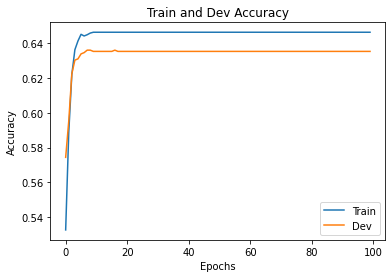

output_motivational/Loss(4).jpg saved!


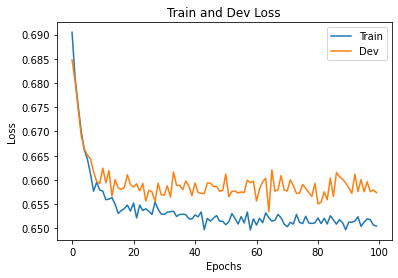

********** Configuration:  4
Classification type:  motivational
Max length of sentence:  32
Cat or Ave over the output: Averaging
Batch size:  150
Number of features: 768
Epochs:  100
********** Results:
Metrics for test data:
Accuracy score: 0.662
macro precision: 0.331
macro recall: 0.5
micro precision 0.662
micro recall 0.662
F1 score: 0.398
Configuration number  4 has been runned successfully.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
bert_configuration_run(
    config_num = 4,
    label_type = 'motivational',  # Values: 'motivational', 'overall_sentiment', (or 'humour', 'sarcasm','offensive')
    max_length = 32,              # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 1)     # Either averaging (=1) over all of words or concatenating(=0).

### Config 5 (Average, 64)

Data distribution:
Training distribution per label Counter({1: 2711, 0: 1484})
Val distribution per label Counter({1: 888, 0: 510})
Test distribution per label Counter({1: 926, 0: 473})


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max 

Featurizing fast ...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Featurizing fast ...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Featurizing fast ...
****************** Training ******************
Epoch 0 ( acc_train:0.366,  acc_dev:0.390 ).
Epoch 1 ( acc_train:0.473,  acc_dev:0.583 ).
Epoch 2 ( acc_train:0.610,  acc_dev:0.614 ).
Epoch 3 ( acc_train:0.640,  acc_dev:0.624 ).
Epoch 4 ( acc_train:0.640,  acc_dev:0.632 ).
Epoch 5 ( acc_train:0.643,  acc_dev:0.632 ).
Epoch 6 ( acc_train:0.644,  acc_dev:0.633 ).
Epoch 7 ( acc_train:0.644,  acc_dev:0.634 ).
Epoch 8 ( acc_train:0.643,  acc_dev:0.632 ).
Epoch 9 ( acc_train:0.645,  acc_dev:0.635 ).
Epoch 10 ( acc_train:0.643,  acc_dev:0.632 ).
Epoch 11 ( acc_train:0.646,  acc_dev:0.636 ).
Epoch 12 ( acc_train:0.644,  acc_dev:0.631 ).
Epoch 13 ( acc_train:0.645,  acc_dev:0.635 ).
Epoch 14 ( acc_train:0.645,  acc_dev:0.634 ).
Epoch 15 ( acc_train:0.646,  acc_dev:0.633 ).
Epoch 16 ( acc_train:0.644,  acc_dev:0.635 ).
Epoch 17 ( acc_train:0.645,  acc_dev:0.634 ).
Epoch 18 ( acc_train:0.645,  acc_dev:0.636 ).
Epoch 19 ( acc_train:0.646,  acc_dev:0.634 ).
Epoch 20 ( acc_train:0

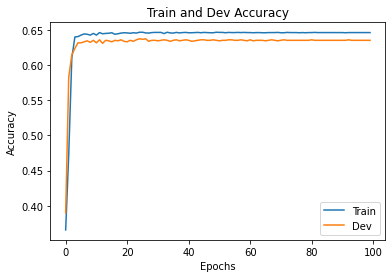

output_motivational/Loss(5).jpg saved!


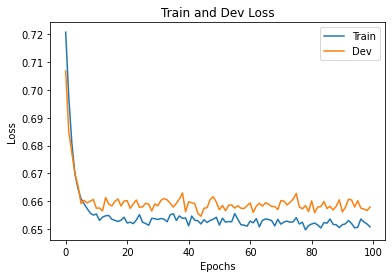

********** Configuration:  5
Classification type:  motivational
Max length of sentence:  64
Cat or Ave over the output: Averaging
Batch size:  150
Number of features: 768
Epochs:  100
********** Results:
Metrics for test data:
Accuracy score: 0.662
macro precision: 0.331
macro recall: 0.5
micro precision 0.662
micro recall 0.662
F1 score: 0.398
Configuration number  5 has been runned successfully.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
bert_configuration_run(
    config_num = 5,
    label_type = 'motivational',  # Values: 'motivational', 'overall_sentiment', (or 'humour', 'sarcasm','offensive')
    max_length = 64,              # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 1 )    # Either averaging (=1) over all of words or concatenating(=0).

### Config 6 (Average, 128)

Data distribution:
Training distribution per label Counter({1: 2711, 0: 1484})
Val distribution per label Counter({1: 888, 0: 510})
Test distribution per label Counter({1: 926, 0: 473})


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max 

Featurizing fast ...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Featurizing fast ...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Featurizing fast ...
****************** Training ******************
Epoch 0 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 1 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 2 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 3 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 4 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 5 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 6 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 7 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 8 ( acc_train:0.645,  acc_dev:0.635 ).
Epoch 9 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 10 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 11 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 12 ( acc_train:0.645,  acc_dev:0.635 ).
Epoch 13 ( acc_train:0.645,  acc_dev:0.635 ).
Epoch 14 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 15 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 16 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 17 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 18 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 19 ( acc_train:0.646,  acc_dev:0.635 ).
Epoch 20 ( acc_train:0

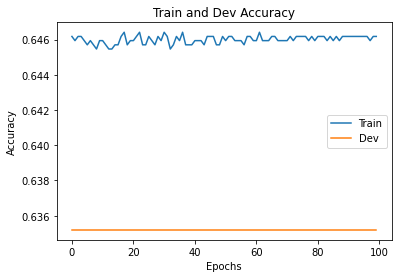

output_motivational/Loss(6).jpg saved!


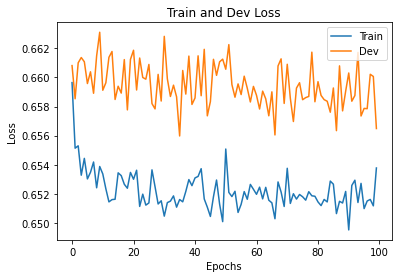

********** Configuration:  6
Classification type:  motivational
Max length of sentence:  128
Cat or Ave over the output: Averaging
Batch size:  150
Number of features: 768
Epochs:  100
********** Results:
Metrics for test data:
Accuracy score: 0.662
macro precision: 0.331
macro recall: 0.5
micro precision 0.662
micro recall 0.662
F1 score: 0.398
Configuration number  6 has been runned successfully.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
bert_configuration_run(
    config_num = 6,
    label_type = 'motivational',  # Values: 'motivational', 'overall_sentiment', (or 'humour', 'sarcasm','offensive')
    max_length = 128,             # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 1)    # Either averaging (=1) over all of words or concatenating(=0).

## BERT, Sentiment, config 1-6

### Config 1 (Concatenation, 32)

Data distribution:
Training distribution per label Counter({2: 2504, 1: 1339, 0: 352})
Val distribution per label Counter({2: 826, 1: 425, 0: 147})
Test distribution per label Counter({2: 830, 1: 437, 0: 132})


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max 

Featurizing fast ...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Featurizing fast ...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Featurizing fast ...
****************** Training ******************
Epoch 0 ( acc_train:0.522,  acc_dev:0.588 ).
Epoch 1 ( acc_train:0.592,  acc_dev:0.577 ).
Epoch 2 ( acc_train:0.584,  acc_dev:0.579 ).
Epoch 3 ( acc_train:0.584,  acc_dev:0.577 ).
Epoch 4 ( acc_train:0.591,  acc_dev:0.590 ).
Epoch 5 ( acc_train:0.594,  acc_dev:0.582 ).
Epoch 6 ( acc_train:0.593,  acc_dev:0.586 ).
Epoch 7 ( acc_train:0.596,  acc_dev:0.579 ).
Epoch 8 ( acc_train:0.595,  acc_dev:0.577 ).
Epoch 9 ( acc_train:0.595,  acc_dev:0.581 ).
Epoch 10 ( acc_train:0.595,  acc_dev:0.587 ).
Epoch 11 ( acc_train:0.597,  acc_dev:0.579 ).
Epoch 12 ( acc_train:0.598,  acc_dev:0.584 ).
Epoch 13 ( acc_train:0.598,  acc_dev:0.573 ).
Epoch 14 ( acc_train:0.601,  acc_dev:0.583 ).
Epoch 15 ( acc_train:0.598,  acc_dev:0.577 ).
Epoch 16 ( acc_train:0.600,  acc_dev:0.589 ).
Epoch 17 ( acc_train:0.603,  acc_dev:0.587 ).
Epoch 18 ( acc_train:0.600,  acc_dev:0.574 ).
Epoch 19 ( acc_train:0.600,  acc_dev:0.582 ).
Epoch 20 ( acc_train:0

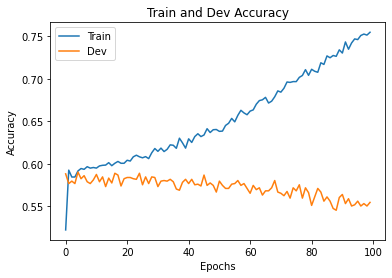

output_overall_sentiment/Loss(1).jpg saved!


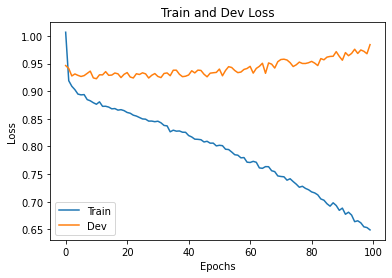

********** Configuration:  1
Classification type:  overall_sentiment
Max length of sentence:  32
Cat or Ave over the output: Concatenation
Batch size:  150
Number of features: 24576
Epochs:  100
********** Results:
Metrics for test data:
Accuracy score: 0.556
macro precision: 0.302
macro recall: 0.334
micro precision 0.556
micro recall 0.556
F1 score: 0.317
Configuration number  1 has been runned successfully.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
bert_configuration_run(
    config_num = 1,
    label_type = 'overall_sentiment',  # Values: 'motivational', 'overall_sentiment', (or 'humour', 'sarcasm','offensive')
    max_length = 32,                   # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 0)         # Either averaging (=1) over all of words or concatenating(=0).

### Config 2 (Concatenation, 64)

Data distribution:
Training distribution per label Counter({2: 2504, 1: 1339, 0: 352})
Val distribution per label Counter({2: 826, 1: 425, 0: 147})
Test distribution per label Counter({2: 830, 1: 437, 0: 132})


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max 

Featurizing fast ...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Featurizing fast ...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Featurizing fast ...
****************** Training ******************
Epoch 0 ( acc_train:0.556,  acc_dev:0.568 ).
Epoch 1 ( acc_train:0.579,  acc_dev:0.586 ).
Epoch 2 ( acc_train:0.587,  acc_dev:0.584 ).
Epoch 3 ( acc_train:0.596,  acc_dev:0.586 ).
Epoch 4 ( acc_train:0.588,  acc_dev:0.589 ).
Epoch 5 ( acc_train:0.598,  acc_dev:0.593 ).
Epoch 6 ( acc_train:0.595,  acc_dev:0.588 ).
Epoch 7 ( acc_train:0.597,  acc_dev:0.584 ).
Epoch 8 ( acc_train:0.596,  acc_dev:0.589 ).
Epoch 9 ( acc_train:0.596,  acc_dev:0.592 ).
Epoch 10 ( acc_train:0.598,  acc_dev:0.586 ).
Epoch 11 ( acc_train:0.598,  acc_dev:0.587 ).
Epoch 12 ( acc_train:0.593,  acc_dev:0.587 ).
Epoch 13 ( acc_train:0.597,  acc_dev:0.584 ).
Epoch 14 ( acc_train:0.599,  acc_dev:0.589 ).
Epoch 15 ( acc_train:0.604,  acc_dev:0.582 ).
Epoch 16 ( acc_train:0.605,  acc_dev:0.587 ).
Epoch 17 ( acc_train:0.600,  acc_dev:0.582 ).
Epoch 18 ( acc_train:0.606,  acc_dev:0.587 ).
Epoch 19 ( acc_train:0.605,  acc_dev:0.587 ).
Epoch 20 ( acc_train:0

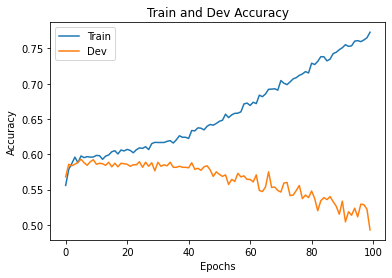

output_overall_sentiment/Loss(2).jpg saved!


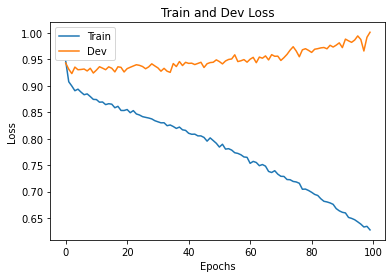

********** Configuration:  2
Classification type:  overall_sentiment
Max length of sentence:  64
Cat or Ave over the output: Concatenation
Batch size:  150
Number of features: 49152
Epochs:  100
********** Results:
Metrics for test data:
Accuracy score: 0.529
macro precision: 0.301
macro recall: 0.332
micro precision 0.529
micro recall 0.529
F1 score: 0.316
Configuration number  2 has been runned successfully.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
bert_configuration_run(
    config_num = 2,
    label_type = 'overall_sentiment',  # Values: 'motivational', 'overall_sentiment', (or 'humour', 'sarcasm','offensive')
    max_length = 64,                   # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 0)         # Either averaging (=1) over all of words or concatenating(=0).

### Config 3 (Concatenation, 128)

Data distribution:
Training distribution per label Counter({2: 2504, 1: 1339, 0: 352})
Val distribution per label Counter({2: 826, 1: 425, 0: 147})
Test distribution per label Counter({2: 830, 1: 437, 0: 132})


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max 

Featurizing fast ...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Featurizing fast ...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Featurizing fast ...
****************** Training ******************
Epoch 0 ( acc_train:0.566,  acc_dev:0.584 ).
Epoch 1 ( acc_train:0.592,  acc_dev:0.564 ).
Epoch 2 ( acc_train:0.592,  acc_dev:0.584 ).
Epoch 3 ( acc_train:0.594,  acc_dev:0.576 ).
Epoch 4 ( acc_train:0.593,  acc_dev:0.578 ).
Epoch 5 ( acc_train:0.597,  acc_dev:0.575 ).
Epoch 6 ( acc_train:0.596,  acc_dev:0.572 ).
Epoch 7 ( acc_train:0.596,  acc_dev:0.583 ).
Epoch 8 ( acc_train:0.598,  acc_dev:0.580 ).
Epoch 9 ( acc_train:0.596,  acc_dev:0.574 ).
Epoch 10 ( acc_train:0.599,  acc_dev:0.571 ).
Epoch 11 ( acc_train:0.598,  acc_dev:0.589 ).
Epoch 12 ( acc_train:0.601,  acc_dev:0.579 ).
Epoch 13 ( acc_train:0.603,  acc_dev:0.577 ).
Epoch 14 ( acc_train:0.601,  acc_dev:0.583 ).
Epoch 15 ( acc_train:0.603,  acc_dev:0.574 ).
Epoch 16 ( acc_train:0.603,  acc_dev:0.573 ).
Epoch 17 ( acc_train:0.605,  acc_dev:0.564 ).
Epoch 18 ( acc_train:0.605,  acc_dev:0.575 ).
Epoch 19 ( acc_train:0.605,  acc_dev:0.582 ).
Epoch 20 ( acc_train:0

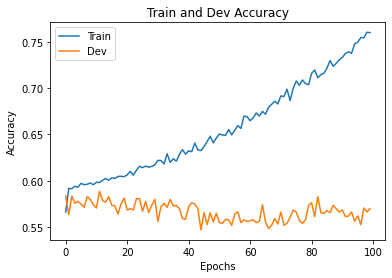

output_overall_sentiment/Loss(3).jpg saved!


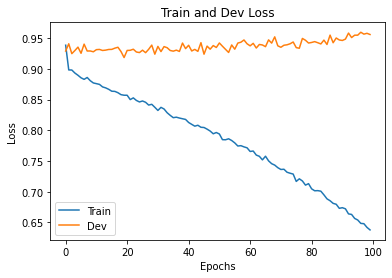

********** Configuration:  3
Classification type:  overall_sentiment
Max length of sentence:  128
Cat or Ave over the output: Concatenation
Batch size:  150
Number of features: 98304
Epochs:  100
********** Results:
Metrics for test data:
Accuracy score: 0.557
macro precision: 0.297
macro recall: 0.331
micro precision 0.557
micro recall 0.557
F1 score: 0.313
Configuration number  3 has been runned successfully.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
bert_configuration_run(
    config_num = 3,
    label_type = 'overall_sentiment',  # Values: 'motivational', 'overall_sentiment', (or 'humour', 'sarcasm','offensive')
    max_length = 128,                  # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 0)         # Either averaging (=1) over all of words or concatenating(=0).

### Config 4 (Average, 32)

Data distribution:
Training distribution per label Counter({2: 2504, 1: 1339, 0: 352})
Val distribution per label Counter({2: 826, 1: 425, 0: 147})
Test distribution per label Counter({2: 830, 1: 437, 0: 132})


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max 

Featurizing fast ...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Featurizing fast ...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Featurizing fast ...
****************** Training ******************
Epoch 0 ( acc_train:0.174,  acc_dev:0.217 ).
Epoch 1 ( acc_train:0.243,  acc_dev:0.305 ).
Epoch 2 ( acc_train:0.343,  acc_dev:0.367 ).
Epoch 3 ( acc_train:0.410,  acc_dev:0.434 ).
Epoch 4 ( acc_train:0.461,  acc_dev:0.463 ).
Epoch 5 ( acc_train:0.499,  acc_dev:0.516 ).
Epoch 6 ( acc_train:0.544,  acc_dev:0.539 ).
Epoch 7 ( acc_train:0.568,  acc_dev:0.548 ).
Epoch 8 ( acc_train:0.571,  acc_dev:0.549 ).
Epoch 9 ( acc_train:0.576,  acc_dev:0.565 ).
Epoch 10 ( acc_train:0.583,  acc_dev:0.565 ).
Epoch 11 ( acc_train:0.586,  acc_dev:0.576 ).
Epoch 12 ( acc_train:0.591,  acc_dev:0.576 ).
Epoch 13 ( acc_train:0.593,  acc_dev:0.581 ).
Epoch 14 ( acc_train:0.596,  acc_dev:0.577 ).
Epoch 15 ( acc_train:0.591,  acc_dev:0.594 ).
Epoch 16 ( acc_train:0.592,  acc_dev:0.587 ).
Epoch 17 ( acc_train:0.595,  acc_dev:0.586 ).
Epoch 18 ( acc_train:0.593,  acc_dev:0.586 ).
Epoch 19 ( acc_train:0.595,  acc_dev:0.587 ).
Epoch 20 ( acc_train:0

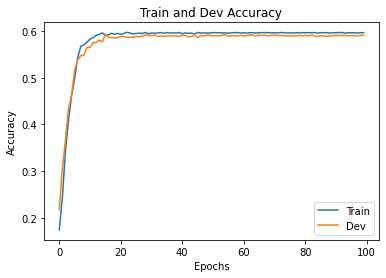

output_overall_sentiment/Loss(4).jpg saved!


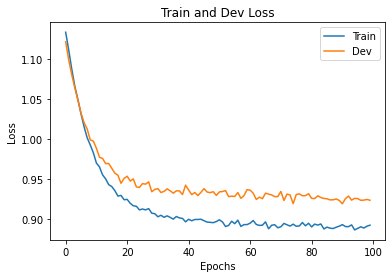

********** Configuration:  4
Classification type:  overall_sentiment
Max length of sentence:  32
Cat or Ave over the output: Averaging
Batch size:  150
Number of features: 768
Epochs:  100
********** Results:
Metrics for test data:
Accuracy score: 0.593
macro precision: 0.198
macro recall: 0.333
micro precision 0.593
micro recall 0.593
F1 score: 0.248
Configuration number  4 has been runned successfully.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
bert_configuration_run(
    config_num = 4,
    label_type = 'overall_sentiment',  # Values: 'motivational', 'overall_sentiment', (or 'humour', 'sarcasm','offensive')
    max_length = 32,                   # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 1)         # Either averaging (=1) over all of words or concatenating(=0).

### Config 5 (Average, 64)

Data distribution:
Training distribution per label Counter({2: 2504, 1: 1339, 0: 352})
Val distribution per label Counter({2: 826, 1: 425, 0: 147})
Test distribution per label Counter({2: 830, 1: 437, 0: 132})


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max 

Featurizing fast ...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Featurizing fast ...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Featurizing fast ...
****************** Training ******************
Epoch 0 ( acc_train:0.194,  acc_dev:0.333 ).
Epoch 1 ( acc_train:0.455,  acc_dev:0.534 ).
Epoch 2 ( acc_train:0.569,  acc_dev:0.566 ).
Epoch 3 ( acc_train:0.580,  acc_dev:0.579 ).
Epoch 4 ( acc_train:0.585,  acc_dev:0.580 ).
Epoch 5 ( acc_train:0.586,  acc_dev:0.582 ).
Epoch 6 ( acc_train:0.587,  acc_dev:0.583 ).
Epoch 7 ( acc_train:0.587,  acc_dev:0.589 ).
Epoch 8 ( acc_train:0.588,  acc_dev:0.590 ).
Epoch 9 ( acc_train:0.588,  acc_dev:0.583 ).
Epoch 10 ( acc_train:0.591,  acc_dev:0.582 ).
Epoch 11 ( acc_train:0.589,  acc_dev:0.589 ).
Epoch 12 ( acc_train:0.589,  acc_dev:0.587 ).
Epoch 13 ( acc_train:0.591,  acc_dev:0.584 ).
Epoch 14 ( acc_train:0.589,  acc_dev:0.588 ).
Epoch 15 ( acc_train:0.590,  acc_dev:0.590 ).
Epoch 16 ( acc_train:0.593,  acc_dev:0.586 ).
Epoch 17 ( acc_train:0.591,  acc_dev:0.585 ).
Epoch 18 ( acc_train:0.593,  acc_dev:0.586 ).
Epoch 19 ( acc_train:0.594,  acc_dev:0.584 ).
Epoch 20 ( acc_train:0

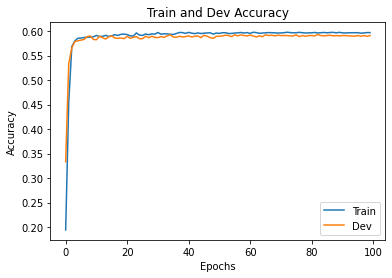

output_overall_sentiment/Loss(5).jpg saved!


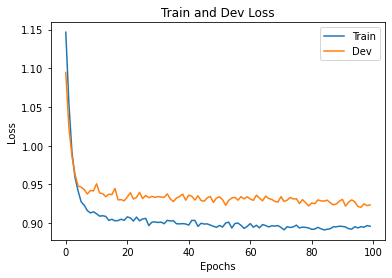

********** Configuration:  5
Classification type:  overall_sentiment
Max length of sentence:  64
Cat or Ave over the output: Averaging
Batch size:  150
Number of features: 768
Epochs:  100
********** Results:
Metrics for test data:
Accuracy score: 0.594
macro precision: 0.531
macro recall: 0.334
micro precision 0.594
micro recall 0.594
F1 score: 0.41
Configuration number  5 has been runned successfully.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
bert_configuration_run(
    config_num = 5,
    label_type = 'overall_sentiment',  # Values: 'motivational', 'overall_sentiment', (or 'humour', 'sarcasm','offensive')
    max_length = 64,                   # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 1)         # Either averaging (=1) over all of words or concatenating(=0).

### Config 6 (Average, 128)

Data distribution:
Training distribution per label Counter({2: 2504, 1: 1339, 0: 352})
Val distribution per label Counter({2: 826, 1: 425, 0: 147})
Test distribution per label Counter({2: 830, 1: 437, 0: 132})


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max 

Featurizing fast ...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Featurizing fast ...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Featurizing fast ...
****************** Training ******************
Epoch 0 ( acc_train:0.525,  acc_dev:0.589 ).
Epoch 1 ( acc_train:0.595,  acc_dev:0.591 ).
Epoch 2 ( acc_train:0.596,  acc_dev:0.591 ).
Epoch 3 ( acc_train:0.596,  acc_dev:0.590 ).
Epoch 4 ( acc_train:0.596,  acc_dev:0.591 ).
Epoch 5 ( acc_train:0.596,  acc_dev:0.590 ).
Epoch 6 ( acc_train:0.597,  acc_dev:0.591 ).
Epoch 7 ( acc_train:0.596,  acc_dev:0.590 ).
Epoch 8 ( acc_train:0.596,  acc_dev:0.590 ).
Epoch 9 ( acc_train:0.596,  acc_dev:0.591 ).
Epoch 10 ( acc_train:0.595,  acc_dev:0.592 ).
Epoch 11 ( acc_train:0.595,  acc_dev:0.591 ).
Epoch 12 ( acc_train:0.594,  acc_dev:0.589 ).
Epoch 13 ( acc_train:0.594,  acc_dev:0.589 ).
Epoch 14 ( acc_train:0.596,  acc_dev:0.589 ).
Epoch 15 ( acc_train:0.596,  acc_dev:0.589 ).
Epoch 16 ( acc_train:0.595,  acc_dev:0.591 ).
Epoch 17 ( acc_train:0.594,  acc_dev:0.589 ).
Epoch 18 ( acc_train:0.595,  acc_dev:0.589 ).
Epoch 19 ( acc_train:0.595,  acc_dev:0.589 ).
Epoch 20 ( acc_train:0

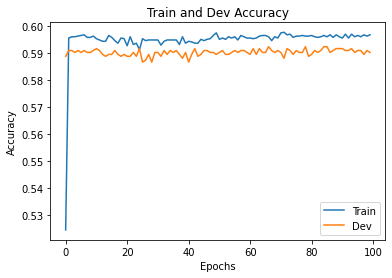

output_overall_sentiment/Loss(6).jpg saved!


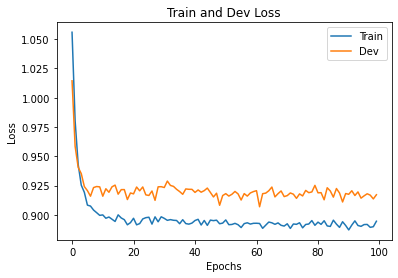

********** Configuration:  6
Classification type:  overall_sentiment
Max length of sentence:  128
Cat or Ave over the output: Averaging
Batch size:  150
Number of features: 768
Epochs:  100
********** Results:
Metrics for test data:
Accuracy score: 0.593
macro precision: 0.198
macro recall: 0.333
micro precision 0.593
micro recall 0.593
F1 score: 0.248
Configuration number  6 has been runned successfully.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
bert_configuration_run(
    config_num = 6,
    label_type = 'overall_sentiment',  # Values: 'motivational', 'overall_sentiment', (or 'humour', 'sarcasm','offensive')
    max_length = 128,                  # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 1)         # Either averaging (=1) over all of words or concatenating(=0).

# **GPT2 Models**

## GPT2 Requirement

In [ ]:
from transformers import GPT2Tokenizer, GPT2Model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
class FeatureGPT2Representation:
  def __init__(self,
               batch_size,
               max_length=32,
               model_type='gpt2'               
               ):
    # received the train,dev, test dataset
    # find the bert representation of the data and save it

    self.model_type = model_type
    self.batch_size= batch_size
    self.max_length = max_length
    self.tokenizer = GPT2Tokenizer.from_pretrained(model_type)
    self.model = GPT2Model.from_pretrained(model_type)
   
    # Bert representation of the dataset including train, val, and test.
    # self.train = self.prepare_data(x_train, y_train)
    # self.val =  self.prepare_data(x_val, y_val)
    # self.test = self.prepare_data(x_test, y_test)

  def __call__(self, x, y):
    self.model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # device = torch.device('cuda:0')
    self.model.to(device)
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True
    data_tokenized=[self.tokenizer(item) for item in x]

    prepared_data = self.prepare_data(x, y, self.max_length)

    hidden_states=[]

    for batch in prepared_data:
      batch = tuple(b.to(device) for b in batch)
        
      inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1]
                  }
      with torch.no_grad():
        outputs = self.model(**inputs)
      hidden_states.append(outputs.last_hidden_state)
  

    return hidden_states



  def prepare_data(self, 
                   data,
                   labels,
                   max_length, 
                   add_special_tokens=True, 
                   return_attention_mask=True, 
                   pad_to_max_length=True ):
      

      self.tokenizer.pad_token = tokenizer.eos_token
      encoded_data = self.tokenizer.batch_encode_plus(data,
                                                add_special_tokens=add_special_tokens, 
                                                return_attention_mask=return_attention_mask, 
                                                pad_to_max_length=pad_to_max_length, 
                                                max_length=self.max_length, 
                                                return_tensors='pt')
      input_ids_data = encoded_data['input_ids']
      attention_masks_data = encoded_data['attention_mask']
      labels_data = torch.tensor(labels)

      encoded_data = tf.concat([input_ids_data,attention_masks_data],1)
      encoded_data = np.array(encoded_data)

      # sm = SMOTE(random_state=2)
      # X_train_res, labels_train = sm.fit_resample(encoded_x_train,y_train.ravel())
      encoded_data = torch.Tensor(encoded_data)
      encoded_data= encoded_data.type(torch.int)

      input_ids, attention_masks = torch.split(encoded_data,self.max_length, 1)
      input_ids=input_ids.type(torch.int)
      attention_masks = attention_masks.type(torch.int)

      dataset = TensorDataset(input_ids, attention_masks, torch.tensor(labels))
      
      dataloader_data = DataLoader(dataset, 
                                sampler=RandomSampler(dataset), 
                                batch_size=self.batch_size)
      return dataloader_data

In [ ]:
import os.path
import pickle
def featurized_data_GPT2(
    x_train,y_train,x_val,y_val,x_test,y_test,
    featurizer, feature_vectorization=0):
  gpt2_train = GPT2Featured(x_train,y_train)
  gpt2_train_flattened=vectorized_features(gpt2_train,feature_vectorization=0)

  gpt2_val = GPT2Featured(x_val,y_val)
  gpt2_val_flattened = vectorized_features(gpt2_val,feature_vectorization=0)

  gpt2_test = GPT2Featured(x_test,y_test)
  gpt2_test_flattened = vectorized_features(gpt2_test,feature_vectorization=0)

  return gpt2_train_flattened,gpt2_val_flattened,gpt2_test_flattened

In [ ]:
GPT2Featured  = FeatureGPT2Representation(batch_size=150)

def GPT2_configuration_run(
    config_num,
    label_type = 'motivational',   # Values: 'humour', 'sarcasm','offensive', 'motivational', or 'overall_sentiment'
    max_length = 32,               # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 0      # Either averaging (=1) over all of words or concatenating(=0).
    ):
  batch_size=150
  num_epochs=100
  lr = 0.0001 # 0.01, 0.001, 0.0001
  drop_out = 0.4

  x_train,y_train,x_val,y_val,x_test,y_test = create_dataset(Classification_lapel_type = label_type)

  gpt2_train_flattened,gpt2_val_flattened,gpt2_test_flattened = featurized_data_GPT2(
      x_train,y_train,
      x_val,y_val,
      x_test,y_test,
      featurizer=GPT2Featured,
      feature_vectorization=0)
  num_features=np.shape(gpt2_train_flattened)[1]
  feature_vec= ['Concatenation', 'Averaging']
  print('********** Configuration '+str(config_num)+' :')
  print('Classification type: ', label_type)
  print('Max length of sentence: ', max_length)
  print('Cat or Ave over the output:', feature_vec[feature_vectorization])
  print('Batch size: ', batch_size)
  print('Epochs: ', num_epochs)
  
  print('Number of features:',num_features)

  model = Sentimentclassifier(num_features=num_features, 
                            num_hidden1 = 2096, 
                            num_hidden2 = 32,
                            num_labels=len(set(y_train)),
                            drop_out = drop_out)
  weight_adjuster = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
  # weight_adjuster = torch.optim.Adam(model.parameters())
  loss_f = nn.CrossEntropyLoss()

  train(model,
      label_type = label_type,
      config = config_num,
      trn = gpt2_train_flattened,
      trn_labels = torch.LongTensor(y_train),
      val = gpt2_val_flattened,
      val_labels = torch.LongTensor(y_val),
      weight_adjuster=weight_adjuster,
      loss_fn=loss_f,
      batch_size=batch_size, #64
      num_epochs=num_epochs) #15

  y_test = torch.LongTensor(y_test)
  predictions, _ = model.predict(torch.FloatTensor(gpt2_test_flattened))

  accuracy = accuracy_score(y_test, predictions)
  macro_precision = precision_score(y_test, predictions, average='macro')
  macro_recall = recall_score(y_test, predictions, average='macro')
  micro_precision = precision_score(y_test, predictions, average='micro')
  micro_recall = recall_score(y_test, predictions, average='micro')
  f1_score =  2*(macro_precision*macro_recall)/(macro_precision+macro_recall)
  #f1_score = f1_score(dev_labels, predictions, average='micro')
  print_results(accuracy, macro_precision, macro_recall, micro_precision, micro_recall, f1_score, 'test', rounded=3)
  print('Configuration number ',str(config_num)+' has been runned successfully.') 

  

## GPT2 Motivational, config 7-12

### Config 7

Data distribution:
Training distribution per label Counter({1: 2711, 0: 1484})
Val distribution per label Counter({1: 888, 0: 510})
Test distribution per label Counter({1: 926, 0: 473})


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Featurizing fast ...
Featurizing fast ...
Featurizing fast ...
********** Configuration 7 :
Classification type:  motivational
Max length of sentence:  32
Cat or Ave over the output: Concatenation
Batch size:  150
Epochs:  100
Number of features: 24576
****************** Training ******************
Epoch 0 ( acc_train:0.548,  acc_dev:0.454 ).
Epoch 1 ( acc_train:0.543,  acc_dev:0.406 ).
Epoch 2 ( acc_train:0.545,  acc_dev:0.567 ).
Epoch 3 ( acc_train:0.574,  acc_dev:0.577 ).
Epoch 4 ( acc_train:0.583,  acc_dev:0.520 ).
Epoch 5 ( acc_train:0.581,  acc_dev:0.544 ).
Epoch 6 ( acc_train:0.577,  acc_dev:0.573 ).
Epoch 7 ( acc_train:0.600,  acc_dev:0.552 ).
Epoch 8 ( acc_train:0.605,  acc_dev:0.554 ).
Epoch 9 ( acc_train:0.601,  acc_dev:0.529 ).
Epoch 10 ( acc_train:0.615,  acc_dev:0.557 ).
Epoch 11 ( acc_train:0.619,  acc_dev:0.553 ).
Epoch 12 ( acc_train:0.629,  acc_dev:0.512 ).
Epoch 13 ( acc_train:0.618,  acc_dev:0.529 ).
Epoch 14 ( acc_train:0.622,  acc_dev:0.560 ).
Epoch 15 ( acc_train

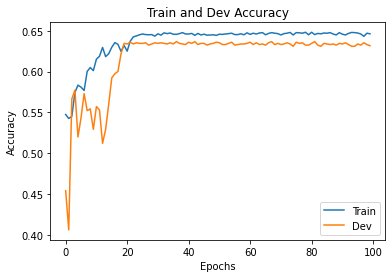

output_motivational/Loss(7).jpg saved!


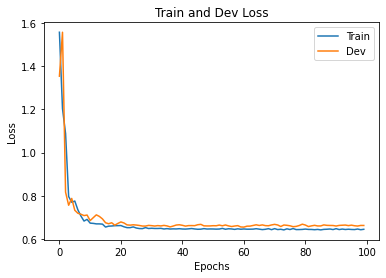

Metrics for test data:
Accuracy score: 0.662
macro precision: 0.581
macro recall: 0.501
micro precision 0.662
micro recall 0.662
F1 score: 0.538
Configuration number  7 has been runned successfully.


In [ ]:
GPT2_configuration_run(
    config_num = 7,
    label_type = 'motivational',   # Values: 'humour', 'sarcasm','offensive', 'motivational', or 'overall_sentiment'
    max_length = 32,               # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 0)     # Either averaging (=1) over all of words or concatenating(=0).

### Config 8

Data distribution:
Training distribution per label Counter({1: 2711, 0: 1484})
Val distribution per label Counter({1: 888, 0: 510})
Test distribution per label Counter({1: 926, 0: 473})


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Featurizing fast ...
Featurizing fast ...
Featurizing fast ...
********** Configuration 8 :
Classification type:  motivational
Max length of sentence:  64
Cat or Ave over the output: Concatenation
Batch size:  150
Epochs:  100
Number of features: 24576
****************** Training ******************
Epoch 0 ( acc_train:0.547,  acc_dev:0.406 ).
Epoch 1 ( acc_train:0.546,  acc_dev:0.597 ).
Epoch 2 ( acc_train:0.572,  acc_dev:0.490 ).
Epoch 3 ( acc_train:0.564,  acc_dev:0.584 ).
Epoch 4 ( acc_train:0.590,  acc_dev:0.598 ).
Epoch 5 ( acc_train:0.595,  acc_dev:0.577 ).
Epoch 6 ( acc_train:0.595,  acc_dev:0.536 ).
Epoch 7 ( acc_train:0.611,  acc_dev:0.554 ).
Epoch 8 ( acc_train:0.613,  acc_dev:0.559 ).
Epoch 9 ( acc_train:0.608,  acc_dev:0.530 ).
Epoch 10 ( acc_train:0.615,  acc_dev:0.473 ).
Epoch 11 ( acc_train:0.615,  acc_dev:0.571 ).
Epoch 12 ( acc_train:0.620,  acc_dev:0.571 ).
Epoch 13 ( acc_train:0.618,  acc_dev:0.580 ).
Epoch 14 ( acc_train:0.632,  acc_dev:0.583 ).
Epoch 15 ( acc_train

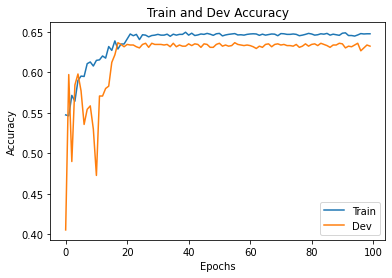

output_motivational/Loss(8).jpg saved!


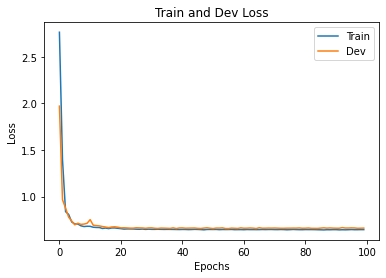

Metrics for test data:
Accuracy score: 0.661
macro precision: 0.498
macro recall: 0.5
micro precision 0.661
micro recall 0.661
F1 score: 0.499
Configuration number  8 has been runned successfully.


In [ ]:
GPT2_configuration_run(
    config_num = 8,
    label_type = 'motivational',   # Values: 'humour', 'sarcasm','offensive', 'motivational', or 'overall_sentiment'
    max_length = 64,               # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 0)     # Either averaging (=1) over all of words or concatenating(=0).

### Config 9

Data distribution:
Training distribution per label Counter({1: 2711, 0: 1484})
Val distribution per label Counter({1: 888, 0: 510})
Test distribution per label Counter({1: 926, 0: 473})


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Featurizing fast ...
Featurizing fast ...
Featurizing fast ...
********** Configuration 9 :
Classification type:  motivational
Max length of sentence:  128
Cat or Ave over the output: Concatenation
Batch size:  150
Epochs:  100
Number of features: 24576
****************** Training ******************
Epoch 0 ( acc_train:0.548,  acc_dev:0.628 ).
Epoch 1 ( acc_train:0.553,  acc_dev:0.391 ).
Epoch 2 ( acc_train:0.555,  acc_dev:0.620 ).
Epoch 3 ( acc_train:0.559,  acc_dev:0.566 ).
Epoch 4 ( acc_train:0.574,  acc_dev:0.590 ).
Epoch 5 ( acc_train:0.571,  acc_dev:0.501 ).
Epoch 6 ( acc_train:0.561,  acc_dev:0.588 ).
Epoch 7 ( acc_train:0.572,  acc_dev:0.554 ).
Epoch 8 ( acc_train:0.594,  acc_dev:0.564 ).
Epoch 9 ( acc_train:0.600,  acc_dev:0.503 ).
Epoch 10 ( acc_train:0.578,  acc_dev:0.545 ).
Epoch 11 ( acc_train:0.593,  acc_dev:0.584 ).
Epoch 12 ( acc_train:0.608,  acc_dev:0.555 ).
Epoch 13 ( acc_train:0.615,  acc_dev:0.524 ).
Epoch 14 ( acc_train:0.607,  acc_dev:0.469 ).
Epoch 15 ( acc_trai

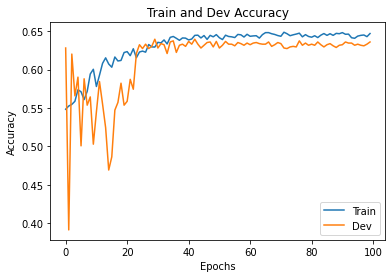

output_motivational/Loss(9).jpg saved!


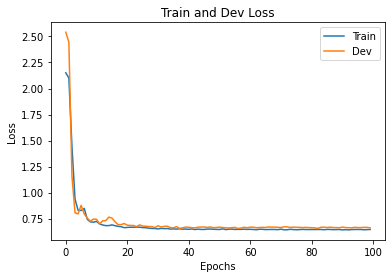

Metrics for test data:
Accuracy score: 0.659
macro precision: 0.51
macro recall: 0.5
micro precision 0.659
micro recall 0.659
F1 score: 0.505
Configuration number  9 has been runned successfully.


In [ ]:
GPT2_configuration_run(
    config_num = 9,
    label_type = 'motivational',   # Values: 'humour', 'sarcasm','offensive', 'motivational', or 'overall_sentiment'
    max_length = 128,              # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 0)     # Either averaging (=1) over all of words or concatenating(=0).

### Config 10

Data distribution:
Training distribution per label Counter({1: 2711, 0: 1484})
Val distribution per label Counter({1: 888, 0: 510})
Test distribution per label Counter({1: 926, 0: 473})


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Featurizing fast ...
Featurizing fast ...
Featurizing fast ...
********** Configuration 10 :
Classification type:  motivational
Max length of sentence:  32
Cat or Ave over the output: Averaging
Batch size:  150
Epochs:  100
Number of features: 24576
****************** Training ******************
Epoch 0 ( acc_train:0.550,  acc_dev:0.377 ).
Epoch 1 ( acc_train:0.538,  acc_dev:0.612 ).
Epoch 2 ( acc_train:0.577,  acc_dev:0.572 ).
Epoch 3 ( acc_train:0.587,  acc_dev:0.528 ).
Epoch 4 ( acc_train:0.596,  acc_dev:0.556 ).
Epoch 5 ( acc_train:0.588,  acc_dev:0.538 ).
Epoch 6 ( acc_train:0.612,  acc_dev:0.538 ).
Epoch 7 ( acc_train:0.611,  acc_dev:0.468 ).
Epoch 8 ( acc_train:0.601,  acc_dev:0.545 ).
Epoch 9 ( acc_train:0.609,  acc_dev:0.567 ).
Epoch 10 ( acc_train:0.617,  acc_dev:0.568 ).
Epoch 11 ( acc_train:0.619,  acc_dev:0.581 ).
Epoch 12 ( acc_train:0.618,  acc_dev:0.579 ).
Epoch 13 ( acc_train:0.617,  acc_dev:0.602 ).
Epoch 14 ( acc_train:0.622,  acc_dev:0.624 ).
Epoch 15 ( acc_train:0.

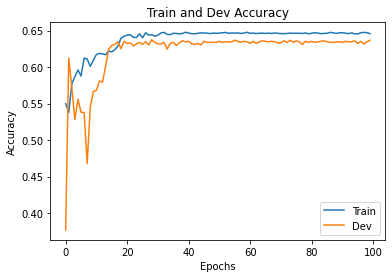

output_motivational/Loss(10).jpg saved!


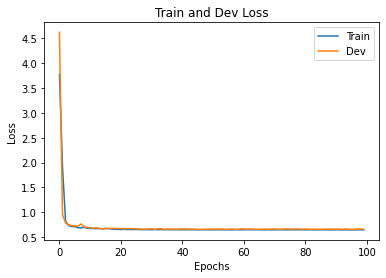

Metrics for test data:
Accuracy score: 0.661
macro precision: 0.531
macro recall: 0.5
micro precision 0.661
micro recall 0.661
F1 score: 0.515
Configuration number  10 has been runned successfully.


In [ ]:
GPT2_configuration_run(
    config_num = 10,
    label_type = 'motivational',   # Values: 'humour', 'sarcasm','offensive', 'motivational', or 'overall_sentiment'
    max_length = 32,               # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 1)     # Either averaging (=1) over all of words or concatenating(=0).

### Config 11

Data distribution:
Training distribution per label Counter({1: 2711, 0: 1484})
Val distribution per label Counter({1: 888, 0: 510})
Test distribution per label Counter({1: 926, 0: 473})


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Featurizing fast ...
Featurizing fast ...
Featurizing fast ...
********** Configuration 11 :
Classification type:  motivational
Max length of sentence:  64
Cat or Ave over the output: Averaging
Batch size:  150
Epochs:  100
Number of features: 24576
****************** Training ******************
Epoch 0 ( acc_train:0.550,  acc_dev:0.509 ).
Epoch 1 ( acc_train:0.552,  acc_dev:0.594 ).
Epoch 2 ( acc_train:0.562,  acc_dev:0.589 ).
Epoch 3 ( acc_train:0.574,  acc_dev:0.515 ).
Epoch 4 ( acc_train:0.582,  acc_dev:0.490 ).
Epoch 5 ( acc_train:0.582,  acc_dev:0.592 ).
Epoch 6 ( acc_train:0.590,  acc_dev:0.594 ).
Epoch 7 ( acc_train:0.614,  acc_dev:0.582 ).
Epoch 8 ( acc_train:0.601,  acc_dev:0.539 ).
Epoch 9 ( acc_train:0.603,  acc_dev:0.575 ).
Epoch 10 ( acc_train:0.619,  acc_dev:0.564 ).
Epoch 11 ( acc_train:0.599,  acc_dev:0.596 ).
Epoch 12 ( acc_train:0.627,  acc_dev:0.557 ).
Epoch 13 ( acc_train:0.619,  acc_dev:0.561 ).
Epoch 14 ( acc_train:0.620,  acc_dev:0.541 ).
Epoch 15 ( acc_train:0.

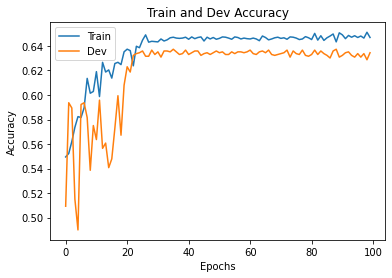

output_motivational/Loss(11).jpg saved!


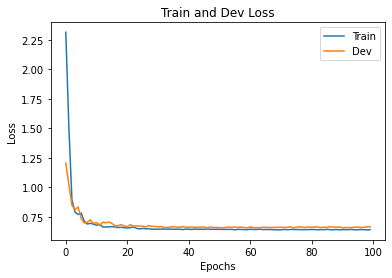

Metrics for test data:
Accuracy score: 0.656
macro precision: 0.38
macro recall: 0.496
micro precision 0.656
micro recall 0.656
F1 score: 0.43
Configuration number  11 has been runned successfully.


In [ ]:
GPT2_configuration_run(
    config_num = 11,
    label_type = 'motivational',   # Values: 'humour', 'sarcasm','offensive', 'motivational', or 'overall_sentiment'
    max_length = 64,               # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 1)     # Either averaging (=1) over all of words or concatenating(=0).

### Config 12

Data distribution:
Training distribution per label Counter({1: 2711, 0: 1484})
Val distribution per label Counter({1: 888, 0: 510})
Test distribution per label Counter({1: 926, 0: 473})


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Featurizing fast ...
Featurizing fast ...
Featurizing fast ...
********** Configuration 12 :
Classification type:  motivational
Max length of sentence:  128
Cat or Ave over the output: Averaging
Batch size:  150
Epochs:  100
Number of features: 24576
****************** Training ******************
Epoch 0 ( acc_train:0.546,  acc_dev:0.412 ).
Epoch 1 ( acc_train:0.551,  acc_dev:0.421 ).
Epoch 2 ( acc_train:0.556,  acc_dev:0.579 ).
Epoch 3 ( acc_train:0.560,  acc_dev:0.515 ).
Epoch 4 ( acc_train:0.575,  acc_dev:0.487 ).
Epoch 5 ( acc_train:0.578,  acc_dev:0.486 ).
Epoch 6 ( acc_train:0.577,  acc_dev:0.576 ).
Epoch 7 ( acc_train:0.594,  acc_dev:0.553 ).
Epoch 8 ( acc_train:0.583,  acc_dev:0.534 ).
Epoch 9 ( acc_train:0.597,  acc_dev:0.567 ).
Epoch 10 ( acc_train:0.608,  acc_dev:0.570 ).
Epoch 11 ( acc_train:0.608,  acc_dev:0.552 ).
Epoch 12 ( acc_train:0.614,  acc_dev:0.527 ).
Epoch 13 ( acc_train:0.618,  acc_dev:0.539 ).
Epoch 14 ( acc_train:0.610,  acc_dev:0.489 ).
Epoch 15 ( acc_train:0

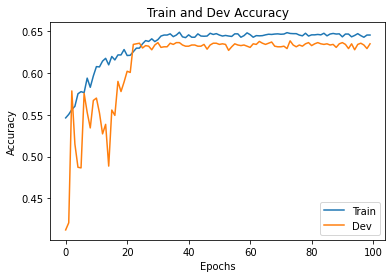

output_motivational/Loss(12).jpg saved!


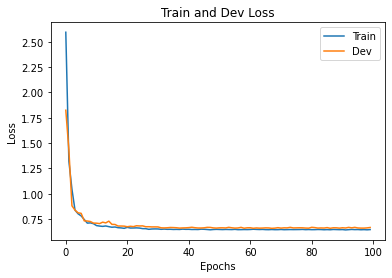

Metrics for test data:
Accuracy score: 0.663
macro precision: 0.631
macro recall: 0.502
micro precision 0.663
micro recall 0.663
F1 score: 0.559
Configuration number  12 has been runned successfully.


In [ ]:
GPT2_configuration_run(
    config_num = 12,
    label_type = 'motivational',   # Values: 'humour', 'sarcasm','offensive', 'motivational', or 'overall_sentiment'
    max_length = 128,               # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 1)     # Either averaging (=1) over all of words or concatenating(=0).

## GPT2, Sentiment, config 7-12

### Config 7

Data distribution:
Training distribution per label Counter({2: 2504, 1: 1339, 0: 352})
Val distribution per label Counter({2: 826, 1: 425, 0: 147})
Test distribution per label Counter({2: 830, 1: 437, 0: 132})


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Featurizing fast ...
Featurizing fast ...
Featurizing fast ...
********** Configuration 7 :
Classification type:  overall_sentiment
Max length of sentence:  32
Cat or Ave over the output: Concatenation
Batch size:  150
Epochs:  100
Number of features: 24576
****************** Training ******************
Epoch 0 ( acc_train:0.460,  acc_dev:0.466 ).
Epoch 1 ( acc_train:0.467,  acc_dev:0.582 ).
Epoch 2 ( acc_train:0.496,  acc_dev:0.506 ).
Epoch 3 ( acc_train:0.511,  acc_dev:0.405 ).
Epoch 4 ( acc_train:0.528,  acc_dev:0.532 ).
Epoch 5 ( acc_train:0.538,  acc_dev:0.557 ).
Epoch 6 ( acc_train:0.530,  acc_dev:0.535 ).
Epoch 7 ( acc_train:0.537,  acc_dev:0.530 ).
Epoch 8 ( acc_train:0.539,  acc_dev:0.495 ).
Epoch 9 ( acc_train:0.544,  acc_dev:0.485 ).
Epoch 10 ( acc_train:0.547,  acc_dev:0.551 ).
Epoch 11 ( acc_train:0.565,  acc_dev:0.573 ).
Epoch 12 ( acc_train:0.554,  acc_dev:0.577 ).
Epoch 13 ( acc_train:0.561,  acc_dev:0.570 ).
Epoch 14 ( acc_train:0.557,  acc_dev:0.577 ).
Epoch 15 ( acc_

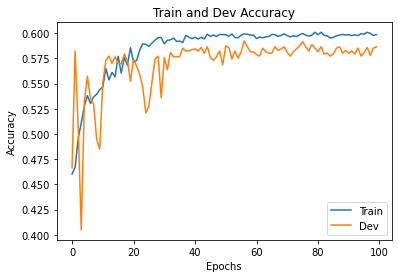

output_overall_sentiment/Loss(7).jpg saved!


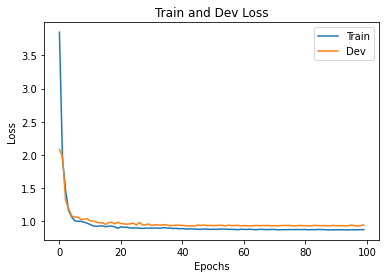

Metrics for test data:
Accuracy score: 0.587
macro precision: 0.317
macro recall: 0.335
micro precision 0.587
micro recall 0.587
F1 score: 0.326
Configuration number  7 has been runned successfully.


In [ ]:
GPT2_configuration_run(
    config_num = 7,
    label_type = 'overall_sentiment',   # Values: 'motivational', 'overall_sentiment', (or 'humour', 'sarcasm','offensive') 
    max_length = 32,                    # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 0)          # Either averaging (=1) over all of words or concatenating(=0).

### Config 8

Data distribution:
Training distribution per label Counter({2: 2504, 1: 1339, 0: 352})
Val distribution per label Counter({2: 826, 1: 425, 0: 147})
Test distribution per label Counter({2: 830, 1: 437, 0: 132})


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Featurizing fast ...
Featurizing fast ...
Featurizing fast ...
********** Configuration 8 :
Classification type:  overall_sentiment
Max length of sentence:  64
Cat or Ave over the output: Concatenation
Batch size:  150
Epochs:  100
Number of features: 24576
****************** Training ******************
Epoch 0 ( acc_train:0.459,  acc_dev:0.483 ).
Epoch 1 ( acc_train:0.455,  acc_dev:0.368 ).
Epoch 2 ( acc_train:0.482,  acc_dev:0.529 ).
Epoch 3 ( acc_train:0.519,  acc_dev:0.515 ).
Epoch 4 ( acc_train:0.516,  acc_dev:0.488 ).
Epoch 5 ( acc_train:0.525,  acc_dev:0.549 ).
Epoch 6 ( acc_train:0.532,  acc_dev:0.478 ).
Epoch 7 ( acc_train:0.538,  acc_dev:0.526 ).
Epoch 8 ( acc_train:0.542,  acc_dev:0.526 ).
Epoch 9 ( acc_train:0.540,  acc_dev:0.505 ).
Epoch 10 ( acc_train:0.545,  acc_dev:0.544 ).
Epoch 11 ( acc_train:0.553,  acc_dev:0.533 ).
Epoch 12 ( acc_train:0.546,  acc_dev:0.525 ).
Epoch 13 ( acc_train:0.548,  acc_dev:0.524 ).
Epoch 14 ( acc_train:0.549,  acc_dev:0.546 ).
Epoch 15 ( acc_

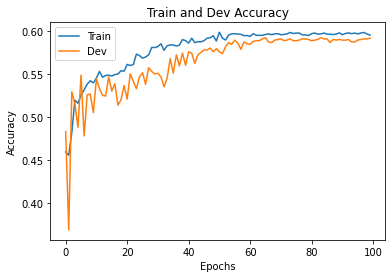

output_overall_sentiment/Loss(8).jpg saved!


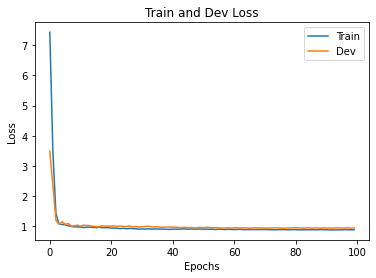

Metrics for test data:
Accuracy score: 0.593
macro precision: 0.309
macro recall: 0.334
micro precision 0.593
micro recall 0.593
F1 score: 0.321
Configuration number  8 has been runned successfully.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
GPT2_configuration_run(
    config_num = 8,
    label_type = 'overall_sentiment',   # Values: 'motivational', 'overall_sentiment', (or 'humour', 'sarcasm','offensive') 
    max_length = 64,                    # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 0)          # Either averaging (=1) over all of words or concatenating(=0).

### Config 9

Data distribution:
Training distribution per label Counter({2: 2504, 1: 1339, 0: 352})
Val distribution per label Counter({2: 826, 1: 425, 0: 147})
Test distribution per label Counter({2: 830, 1: 437, 0: 132})


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Featurizing fast ...
Featurizing fast ...
Featurizing fast ...
********** Configuration 9 :
Classification type:  overall_sentiment
Max length of sentence:  128
Cat or Ave over the output: Concatenation
Batch size:  150
Epochs:  100
Number of features: 24576
****************** Training ******************
Epoch 0 ( acc_train:0.467,  acc_dev:0.197 ).
Epoch 1 ( acc_train:0.456,  acc_dev:0.457 ).
Epoch 2 ( acc_train:0.519,  acc_dev:0.481 ).
Epoch 3 ( acc_train:0.533,  acc_dev:0.448 ).
Epoch 4 ( acc_train:0.542,  acc_dev:0.497 ).
Epoch 5 ( acc_train:0.549,  acc_dev:0.512 ).
Epoch 6 ( acc_train:0.558,  acc_dev:0.538 ).
Epoch 7 ( acc_train:0.570,  acc_dev:0.547 ).
Epoch 8 ( acc_train:0.562,  acc_dev:0.554 ).
Epoch 9 ( acc_train:0.567,  acc_dev:0.486 ).
Epoch 10 ( acc_train:0.563,  acc_dev:0.559 ).
Epoch 11 ( acc_train:0.579,  acc_dev:0.541 ).
Epoch 12 ( acc_train:0.575,  acc_dev:0.539 ).
Epoch 13 ( acc_train:0.580,  acc_dev:0.526 ).
Epoch 14 ( acc_train:0.574,  acc_dev:0.544 ).
Epoch 15 ( acc

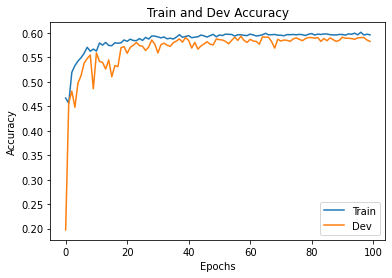

output_overall_sentiment/Loss(9).jpg saved!


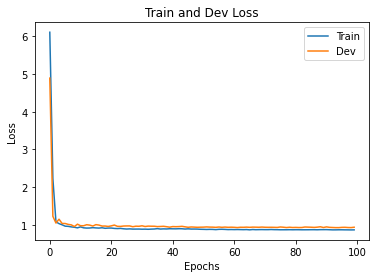

Metrics for test data:
Accuracy score: 0.586
macro precision: 0.327
macro recall: 0.335
micro precision 0.586
micro recall 0.586
F1 score: 0.331
Configuration number  9 has been runned successfully.


In [ ]:
GPT2_configuration_run(
    config_num = 9,
    label_type = 'overall_sentiment',   # Values: 'motivational', 'overall_sentiment', (or 'humour', 'sarcasm','offensive') 
    max_length = 128,                   # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 0)          # Either averaging (=1) over all of words or concatenating(=0).

### Config 10

Data distribution:
Training distribution per label Counter({2: 2504, 1: 1339, 0: 352})
Val distribution per label Counter({2: 826, 1: 425, 0: 147})
Test distribution per label Counter({2: 830, 1: 437, 0: 132})


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Featurizing fast ...
Featurizing fast ...
Featurizing fast ...
********** Configuration 10 :
Classification type:  overall_sentiment
Max length of sentence:  32
Cat or Ave over the output: Averaging
Batch size:  150
Epochs:  100
Number of features: 24576
****************** Training ******************
Epoch 0 ( acc_train:0.457,  acc_dev:0.221 ).
Epoch 1 ( acc_train:0.473,  acc_dev:0.517 ).
Epoch 2 ( acc_train:0.491,  acc_dev:0.441 ).
Epoch 3 ( acc_train:0.492,  acc_dev:0.361 ).
Epoch 4 ( acc_train:0.513,  acc_dev:0.467 ).
Epoch 5 ( acc_train:0.526,  acc_dev:0.425 ).
Epoch 6 ( acc_train:0.530,  acc_dev:0.416 ).
Epoch 7 ( acc_train:0.527,  acc_dev:0.512 ).
Epoch 8 ( acc_train:0.522,  acc_dev:0.491 ).
Epoch 9 ( acc_train:0.542,  acc_dev:0.501 ).
Epoch 10 ( acc_train:0.533,  acc_dev:0.498 ).
Epoch 11 ( acc_train:0.548,  acc_dev:0.514 ).
Epoch 12 ( acc_train:0.556,  acc_dev:0.562 ).
Epoch 13 ( acc_train:0.559,  acc_dev:0.567 ).
Epoch 14 ( acc_train:0.558,  acc_dev:0.574 ).
Epoch 15 ( acc_tra

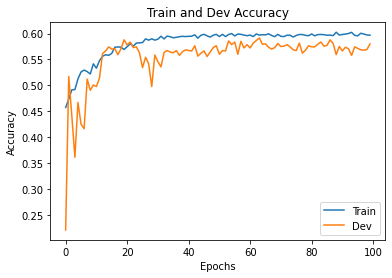

output_overall_sentiment/Loss(10).jpg saved!


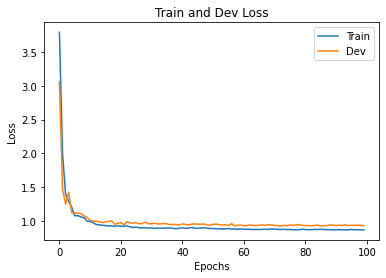

Metrics for test data:
Accuracy score: 0.585
macro precision: 0.304
macro recall: 0.333
micro precision 0.585
micro recall 0.585
F1 score: 0.318
Configuration number  10 has been runned successfully.


In [ ]:
GPT2_configuration_run(
    config_num = 10,
    label_type = 'overall_sentiment',   # Values: 'motivational', 'overall_sentiment', (or 'humour', 'sarcasm','offensive') 
    max_length = 32,                    # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 1)          # Either averaging (=1) over all of words or concatenating(=0).

### Config 11

Data distribution:
Training distribution per label Counter({2: 2504, 1: 1339, 0: 352})
Val distribution per label Counter({2: 826, 1: 425, 0: 147})
Test distribution per label Counter({2: 830, 1: 437, 0: 132})


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Featurizing fast ...
Featurizing fast ...
Featurizing fast ...
********** Configuration 11 :
Classification type:  overall_sentiment
Max length of sentence:  64
Cat or Ave over the output: Averaging
Batch size:  150
Epochs:  100
Number of features: 24576
****************** Training ******************
Epoch 0 ( acc_train:0.471,  acc_dev:0.369 ).
Epoch 1 ( acc_train:0.463,  acc_dev:0.461 ).
Epoch 2 ( acc_train:0.488,  acc_dev:0.474 ).
Epoch 3 ( acc_train:0.502,  acc_dev:0.514 ).
Epoch 4 ( acc_train:0.513,  acc_dev:0.433 ).
Epoch 5 ( acc_train:0.524,  acc_dev:0.446 ).
Epoch 6 ( acc_train:0.521,  acc_dev:0.554 ).
Epoch 7 ( acc_train:0.515,  acc_dev:0.520 ).
Epoch 8 ( acc_train:0.531,  acc_dev:0.508 ).
Epoch 9 ( acc_train:0.545,  acc_dev:0.536 ).
Epoch 10 ( acc_train:0.536,  acc_dev:0.478 ).
Epoch 11 ( acc_train:0.541,  acc_dev:0.429 ).
Epoch 12 ( acc_train:0.540,  acc_dev:0.507 ).
Epoch 13 ( acc_train:0.549,  acc_dev:0.524 ).
Epoch 14 ( acc_train:0.552,  acc_dev:0.534 ).
Epoch 15 ( acc_tra

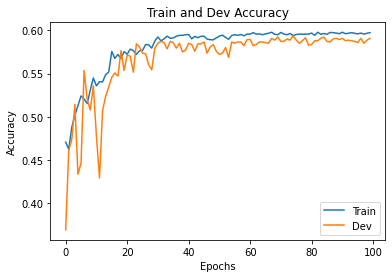

output_overall_sentiment/Loss(11).jpg saved!


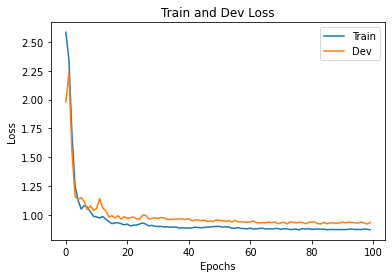

Metrics for test data:
Accuracy score: 0.592
macro precision: 0.42
macro recall: 0.333
micro precision 0.592
micro recall 0.592
F1 score: 0.372
Configuration number  11 has been runned successfully.


In [ ]:
GPT2_configuration_run(
    config_num = 11,
    label_type = 'overall_sentiment',   # Values: 'motivational', 'overall_sentiment', (or 'humour', 'sarcasm','offensive') 
    max_length = 64,                    # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 1)          # Either averaging (=1) over all of words or concatenating(=0).

### Config 12

Data distribution:
Training distribution per label Counter({2: 2504, 1: 1339, 0: 352})
Val distribution per label Counter({2: 826, 1: 425, 0: 147})
Test distribution per label Counter({2: 830, 1: 437, 0: 132})


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Featurizing fast ...
Featurizing fast ...
Featurizing fast ...
********** Configuration 12 :
Classification type:  overall_sentiment
Max length of sentence:  128
Cat or Ave over the output: Averaging
Batch size:  150
Epochs:  100
Number of features: 24576
****************** Training ******************
Epoch 0 ( acc_train:0.468,  acc_dev:0.327 ).
Epoch 1 ( acc_train:0.470,  acc_dev:0.374 ).
Epoch 2 ( acc_train:0.484,  acc_dev:0.472 ).
Epoch 3 ( acc_train:0.523,  acc_dev:0.458 ).
Epoch 4 ( acc_train:0.525,  acc_dev:0.509 ).
Epoch 5 ( acc_train:0.517,  acc_dev:0.560 ).
Epoch 6 ( acc_train:0.534,  acc_dev:0.555 ).
Epoch 7 ( acc_train:0.539,  acc_dev:0.574 ).
Epoch 8 ( acc_train:0.540,  acc_dev:0.557 ).
Epoch 9 ( acc_train:0.542,  acc_dev:0.527 ).
Epoch 10 ( acc_train:0.570,  acc_dev:0.574 ).
Epoch 11 ( acc_train:0.554,  acc_dev:0.578 ).
Epoch 12 ( acc_train:0.565,  acc_dev:0.546 ).
Epoch 13 ( acc_train:0.563,  acc_dev:0.579 ).
Epoch 14 ( acc_train:0.565,  acc_dev:0.568 ).
Epoch 15 ( acc_tr

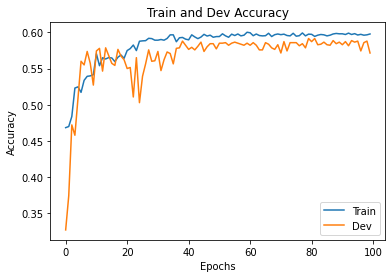

output_overall_sentiment/Loss(12).jpg saved!


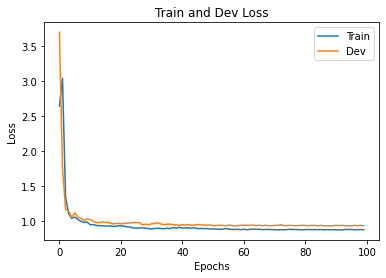

Metrics for test data:
Accuracy score: 0.579
macro precision: 0.297
macro recall: 0.331
micro precision 0.579
micro recall 0.579
F1 score: 0.313
Configuration number  12 has been runned successfully.


In [ ]:
GPT2_configuration_run(
    config_num = 12,
    label_type = 'overall_sentiment',   # Values: 'motivational', 'overall_sentiment', (or 'humour', 'sarcasm','offensive') 
    max_length = 128,               # The maximum length of a sentence. Values: 32, 64, 128 ... 
    feature_vectorization = 1)     # Either averaging (=1) over all of words or concatenating(=0).

# Download outputs

In [ ]:
!zip -r /content/output_motivational.zip /content/output_motivational
from google.colab import files
files.download("/content/output_motivational.zip")

!zip -r /content/output_overall_sentiment.zip /content/output_overall_sentiment
from google.colab import files
files.download("/content/output_overall_sentiment.zip")

  adding: content/output_motivational/ (stored 0%)
  adding: content/output_motivational/Loss(4).jpg (deflated 12%)
  adding: content/output_motivational/Accuracy(8).jpg (deflated 14%)
  adding: content/output_motivational/Loss(8).jpg (deflated 20%)
  adding: content/output_motivational/Loss(7).jpg (deflated 18%)
  adding: content/output_motivational/Loss(1).jpg (deflated 15%)
  adding: content/output_motivational/Accuracy(1).jpg (deflated 14%)
  adding: content/output_motivational/Accuracy(9).jpg (deflated 12%)
  adding: content/output_motivational/Loss(9).jpg (deflated 16%)
  adding: content/output_motivational/Loss(3).jpg (deflated 14%)
  adding: content/output_motivational/Loss(5).jpg (deflated 13%)
  adding: content/output_motivational/Accuracy(10).jpg (deflated 14%)
  adding: content/output_motivational/Accuracy(5).jpg (deflated 18%)
  adding: content/output_motivational/Loss(11).jpg (deflated 17%)
  adding: content/output_motivational/Loss(12).jpg (deflated 17%)
  adding: conten

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/output_overall_sentiment/ (stored 0%)
  adding: content/output_overall_sentiment/Loss(4).jpg (deflated 14%)
  adding: content/output_overall_sentiment/Accuracy(8).jpg (deflated 14%)
  adding: content/output_overall_sentiment/Loss(8).jpg (deflated 20%)
  adding: content/output_overall_sentiment/Loss(7).jpg (deflated 19%)
  adding: content/output_overall_sentiment/Loss(1).jpg (deflated 14%)
  adding: content/output_overall_sentiment/Accuracy(1).jpg (deflated 13%)
  adding: content/output_overall_sentiment/Accuracy(9).jpg (deflated 13%)
  adding: content/output_overall_sentiment/Loss(9).jpg (deflated 20%)
  adding: content/output_overall_sentiment/Loss(3).jpg (deflated 14%)
  adding: content/output_overall_sentiment/Loss(5).jpg (deflated 14%)
  adding: content/output_overall_sentiment/Accuracy(10).jpg (deflated 12%)
  adding: content/output_overall_sentiment/Accuracy(5).jpg (deflated 15%)
  adding: content/output_overall_sentiment/Loss(11).jpg (deflated 16%)
  adding: co

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>